In [1]:
import os
import pandas as pd
import json
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Dataset
from skimage import io
from torchvision.io import read_image
from torch.nn import (
    Module,
    Conv2d,
    Conv1d,
    Linear,
    Dropout2d,
    Dropout1d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [2]:
# Leer el archivo JSON como un DataFrame
with open('data/variables.json', 'r') as f:
    data = json.load(f)

# Obtener los valores de las variables del DataFrame
db_mean = data['mean']
db_std = data['std']
db_min = data['min']
db_max = data['max']
metricas=torch.tensor([db_mean,db_std,db_min,db_max])

In [3]:
class ecgDataset(Dataset):
    def __init__(self, csv_file, metricas):
        self.datos=pd.read_csv(csv_file)
        self.metricas=metricas
        
    def __len__(self):
        return len(self.datos)
    
    def __getitem__(self, idx):
        signal=torch.tensor(json.loads(self.datos.iloc[idx, 0]), dtype=torch.float32)
        label=torch.tensor(self.datos.iloc[idx, 1], dtype=torch.long)
        signal=(signal - self.metricas[2]) / (self.metricas[3] - self.metricas[2])
        return signal, label

dataset = ecgDataset('data/datos.csv', metricas)
train_set, test_set =torch.utils.data.random_split(dataset, [528,131])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

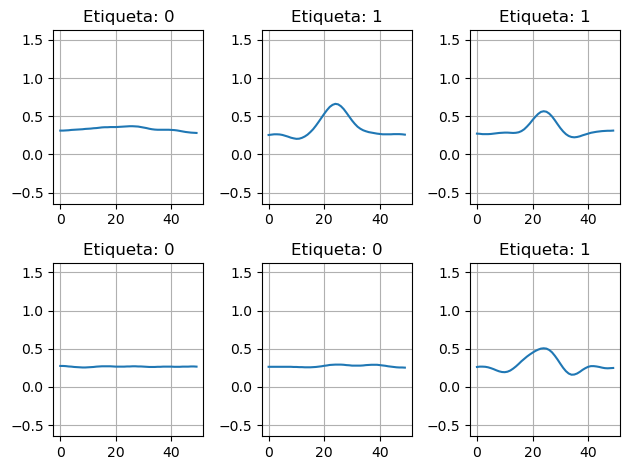

In [4]:
def show_transformed_images(dataset):
    loader=DataLoader(dataset, batch_size=6, shuffle=True)
    batch=next(iter(loader))
    signals, labels = batch
    
    for i in range(len(signals)):
        plt.subplot(2, 3, i+1)
        plt.grid()
        plt.title("Etiqueta: {}".format(labels[i]))
        plt.ylim(metricas[2],metricas[3])
        plt.plot(signals[i])
    plt.tight_layout()
    
show_transformed_images(dataset)

In [5]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn = create_qnn()

In [6]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1)
        self.conv2 = Conv1d(in_channels=16, out_channels=1, kernel_size=5, stride=1)
        self.dropout = Dropout1d()
        self.num_features = self._calculate_num_features()
        self.fc1 = Linear(self.num_features, 64)
        self.fc2 = Linear(64, 8)
        self.fc3 = Linear(8,2)
        self.qnn = TorchConnector(qnn)
        self.fc4 = Linear(1, 1)

    def _calculate_num_features(self):
        # Generar un tensor de ejemplo para calcular la forma de la salida de las capas convolucionales
        x = torch.randn(1, 1, 50)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        num_features = x.view(x.size(0), -1).size(1)
        return num_features
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.qnn(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return cat((x, 1 - x), -1)
    
# Crear una instancia de la red neuronal
model = Net()
loss_func = NLLLoss()
total_loss = []

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 50  # Set number of epochs
loss_list = []  # Store loss history
model.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [2%]	Loss: -0.5122
Training [4%]	Loss: -0.5394
Training [6%]	Loss: -0.5849
Training [8%]	Loss: -0.6048
Training [10%]	Loss: -0.6389
Training [12%]	Loss: -0.6421
Training [14%]	Loss: -0.6696
Training [16%]	Loss: -0.6906
Training [18%]	Loss: -0.6821
Training [20%]	Loss: -0.6862
Training [22%]	Loss: -0.6964
Training [24%]	Loss: -0.6977
Training [26%]	Loss: -0.7385
Training [28%]	Loss: -0.7216
Training [30%]	Loss: -0.7162
Training [32%]	Loss: -0.7292
Training [34%]	Loss: -0.7335
Training [36%]	Loss: -0.7435
Training [38%]	Loss: -0.7460
Training [40%]	Loss: -0.7340
Training [42%]	Loss: -0.7243
Training [44%]	Loss: -0.7541
Training [46%]	Loss: -0.7305
Training [48%]	Loss: -0.7394
Training [50%]	Loss: -0.7220
Training [52%]	Loss: -0.7429
Training [54%]	Loss: -0.7169
Training [56%]	Loss: -0.7304
Training [58%]	Loss: -0.7373
Training [60%]	Loss: -0.7307
Training [62%]	Loss: -0.7254
Training [64%]	Loss: -0.7247
Training [66%]	Loss: -0.7835
Training [68%]	Loss: -0.7156
Training [70%]	Los

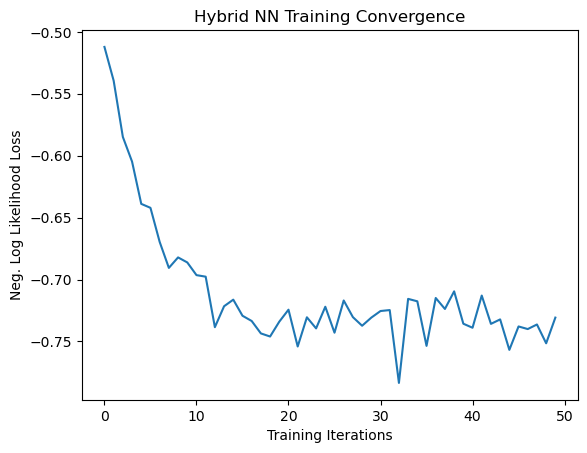

In [8]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [9]:
torch.save(model.state_dict(), "hybridcqmodel.pt")

In [10]:
hybridLoadedModel = Net()
hybridLoadedModel.load_state_dict(torch.load("hybridcqmodel.pt"))

<All keys matched successfully>

Performance on test data:
	Loss: -0.7720
	Accuracy: 94.7%


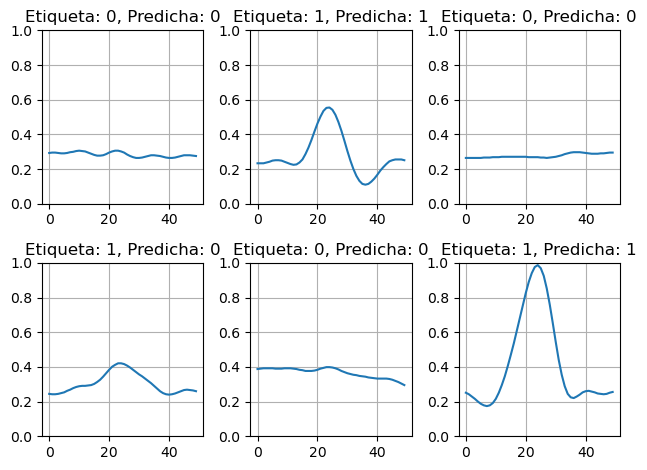

In [11]:
hybridLoadedModel.eval()  # set model to evaluation mode
with no_grad():
    
    all_preds = []
    all_targets = []

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = hybridLoadedModel(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
        if (batch_idx<6):
            plt.subplot(2, 3, batch_idx+1)
            plt.grid()
            plt.title("Etiqueta: {}, Predicha: {}".format(target.numpy()[0], pred.numpy()[0][0]))
            plt.ylim(0,1)
            plt.plot(data.numpy()[0])
            plt.tight_layout()
    
    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / 1 * 100
        )
    )

Matriz de Confusión sin Normalización


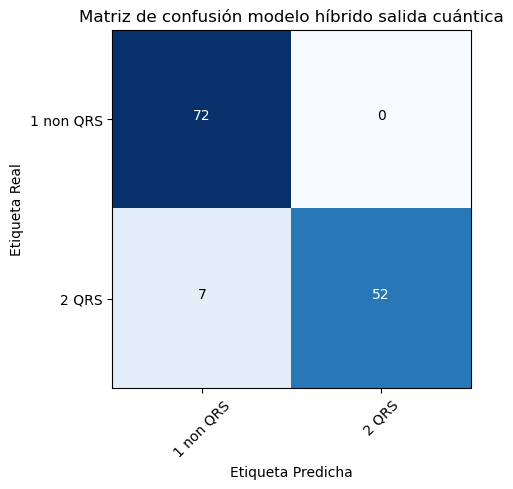

In [13]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de confusión modelo híbrido salida cuántica', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión Normalizada")
    else:
        print('Matriz de Confusión sin Normalización')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

# Ejemplo de uso:
# Suponiendo que 'y_true' son las etiquetas reales y 'y_pred' son las etiquetas predichas por tu modelo
confusion = confusion_matrix(all_targets, all_preds)
plot_confusion_matrix(confusion, classes=['1 non QRS', '2 QRS'], normalize=False)